# Enmarcar el problema y tener una vista amplia

### 1. Objetivo en términos de negocio

Reducir los costos y penalizaciones asociados a concentrados con alto contenido de sílice, entregando a los operadores alertas predictivas 30-60 min antes de que el análisis de laboratorio confirme un sobre-límite.

### 2. ¿Cómo se usará la solución?	

Como un servicio en línea integrado a la sala de control: cada minuto calcula un pronóstico de % Sílice para los próximos 30-60 min. Si el valor proyectado supera un umbral operativo (p.ej. 1,5 %), dispara una advertencia y una recomendación de ajuste (dosificación de reactivos, flujo de aire, pH, etc.).

### 3. Soluciones actuales / workarounds	

* Esperar el resultado de laboratorio (∼60 min de rezago) y ajustar reactivos “a ciegas”.

* Heurísticas basadas en experiencia de los operadores.

### 4. Enfoque del problema	

Aprendizaje supervisado de serie temporal (regresión).

### 5. Cómo medir el desempeño	

Métricas primarias:

• MAPE (objetivo < 8 %)

• RMSE (para comparar con la variabilidad histórica)

Métrica secundaria: 

recall de eventos “críticos” (> 1,8 % Sílice).


Un error porcentual bajo y un alto recall en eventos críticos reducen directamente multas y relaves.

### 6. Desempeño mínimo aceptable	

MAPE ≤ 10 % y capacidad de detectar ≥ 90 % de los eventos donde % Sílice > 1,8 %.

### 7. Solución manual hipotética

Muestrear cada 20 s variables clave y aplicar reglas fijas (“si pH < 10 y ORP > 550 → aumentar 5 % de almidón”). Ineficiente y sensible al ruido.

### 8. Supuestos realizados	

* Las 23 variables de proceso influyen causalmente en el % Sílice.
* El retardo entre variables de proceso y análisis de laboratorio es constante (≈ 60 min).
* Los datos de marzo-septiembre 2017 son representativos de las condiciones actuales.

# Código del Proyecto

In [28]:
# 1. Importar librerías
import pandas as pd
import matplotlib.pyplot as plt

# 2. Cargar el CSV
# Ajusta el nombre de archivo si es distinto
df = pd.read_csv(
    'MiningProcess_Flotation_Plant_Database.csv',
    sep=',',
    decimal=',',
    parse_dates=['date']
)

In [29]:
# 3. Vista rápida
print("Filas y columnas:", df.shape)
df.head()

Filas y columnas: (737453, 24)


,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,2017-03-10 01:00:00,55.2,16.98,3019.53,557.434,395.713,10.0664,1.74,249.214,253.235,...,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,66.91,1.31
1,2017-03-10 01:00:00,55.2,16.98,3024.41,563.965,397.383,10.0672,1.74,249.719,250.532,...,248.994,451.891,429.560,432.939,448.086,496.363,445.922,498.075,66.91,1.31
2,2017-03-10 01:00:00,55.2,16.98,3043.46,568.054,399.668,10.0680,1.74,249.741,247.874,...,248.071,451.240,468.927,434.610,449.688,484.411,447.826,458.567,66.91,1.31
3,2017-03-10 01:00:00,55.2,16.98,3047.36,568.665,397.939,10.0689,1.74,249.917,254.487,...,251.147,452.441,458.165,442.865,446.210,471.411,437.690,427.669,66.91,1.31
4,2017-03-10 01:00:00,55.2,16.98,3033.69,558.167,400.254,10.0697,1.74,250.203,252.136,...,248.928,452.441,452.900,450.523,453.670,462.598,443.682,425.679,66.91,1.31


In [30]:
# 4. Tipos y valores faltantes
print("\n Información general:")
df.info()




 Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737453 entries, 0 to 737452
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   date                          737453 non-null  datetime64[ns]
 1   % Iron Feed                   737453 non-null  float64       
 2   % Silica Feed                 737453 non-null  float64       
 3   Starch Flow                   737453 non-null  float64       
 4   Amina Flow                    737453 non-null  float64       
 5   Ore Pulp Flow                 737453 non-null  float64       
 6   Ore Pulp pH                   737453 non-null  float64       
 7   Ore Pulp Density              737453 non-null  float64       
 8   Flotation Column 01 Air Flow  737453 non-null  float64       
 9   Flotation Column 02 Air Flow  737453 non-null  float64       
 10  Flotation Column 03 Air Flow  737453 non-null  float64   

In [31]:
print("\n Valores faltantes por columna:")
df.isnull().sum()



 Valores faltantes por columna:


date                            0
% Iron Feed                     0
% Silica Feed                   0
Starch Flow                     0
Amina Flow                      0
Ore Pulp Flow                   0
Ore Pulp pH                     0
Ore Pulp Density                0
Flotation Column 01 Air Flow    0
Flotation Column 02 Air Flow    0
Flotation Column 03 Air Flow    0
Flotation Column 04 Air Flow    0
Flotation Column 05 Air Flow    0
Flotation Column 06 Air Flow    0
Flotation Column 07 Air Flow    0
Flotation Column 01 Level       0
Flotation Column 02 Level       0
Flotation Column 03 Level       0
Flotation Column 04 Level       0
Flotation Column 05 Level       0
Flotation Column 06 Level       0
Flotation Column 07 Level       0
% Iron Concentrate              0
% Silica Concentrate            0
dtype: int64

In [32]:
# 5. Estadísticas descriptivas
print("\n Estadísticas básicas:")
df.describe()




 Estadísticas básicas:


,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
count,737453,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,...,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000
mean,2017-06-16 03:27:22.656549376,56.294739,14.651716,2869.140569,488.144697,397.578372,9.767639,1.680380,280.151856,277.159965,...,290.754856,520.244823,522.649555,531.352662,420.320973,425.251706,429.941018,421.021231,65.050068,2.326763
min,2017-03-10 01:00:00,42.740000,1.310000,0.002026,241.669000,376.249000,8.753340,1.519820,175.510000,175.156000,...,185.962000,149.218000,210.752000,126.255000,162.201000,166.991000,155.841000,175.349000,62.050000,0.600000
25%,2017-05-04 23:00:00,52.670000,8.940000,2076.320000,431.796000,394.264000,9.527360,1.647310,250.281000,250.457000,...,256.302000,416.978000,441.883000,411.325000,356.679000,357.653000,358.497000,356.772000,64.370000,1.440000
50%,2017-06-16 15:00:00,56.080000,13.850000,3018.430000,504.393000,399.249000,9.798100,1.697600,299.344000,296.223000,...,299.011000,491.878000,495.956000,494.318000,411.974000,408.773000,424.664575,411.065000,65.210000,2.000000
75%,2017-07-29 07:00:00,59.720000,19.600000,3727.730000,553.257000,402.968000,10.038000,1.728330,300.149000,300.690000,...,301.904000,594.114000,595.464000,601.249000,485.549000,484.329000,492.684000,476.465000,65.860000,3.010000
max,2017-09-09 23:00:00,65.780000,33.400000,6300.230000,739.538000,418.641000,10.808100,1.853250,373.871000,375.992000,...,371.593000,862.274000,828.919000,886.822000,680.359000,675.644000,698.861000,659.902000,68.010000,5.530000
std,NaN,5.157744,6.807439,1215.203734,91.230534,9.699785,0.387007,0.069249,29.621288,30.149357,...,28.670105,131.014924,128.165050,150.842164,91.794432,84.535822,89.862225,84.891491,1.118645,1.125554


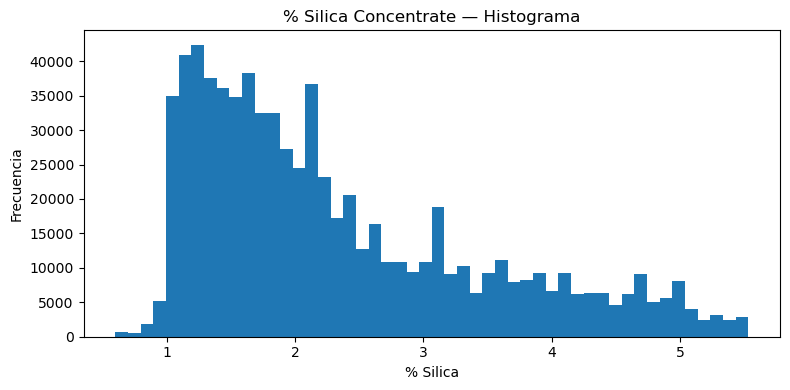

In [33]:
# 6. Distribución del target (% Sílice Concentrate)
plt.figure(figsize=(8,4))
plt.hist(df['% Silica Concentrate'], bins=50)
plt.title('% Silica Concentrate — Histograma')
plt.xlabel('% Silica')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

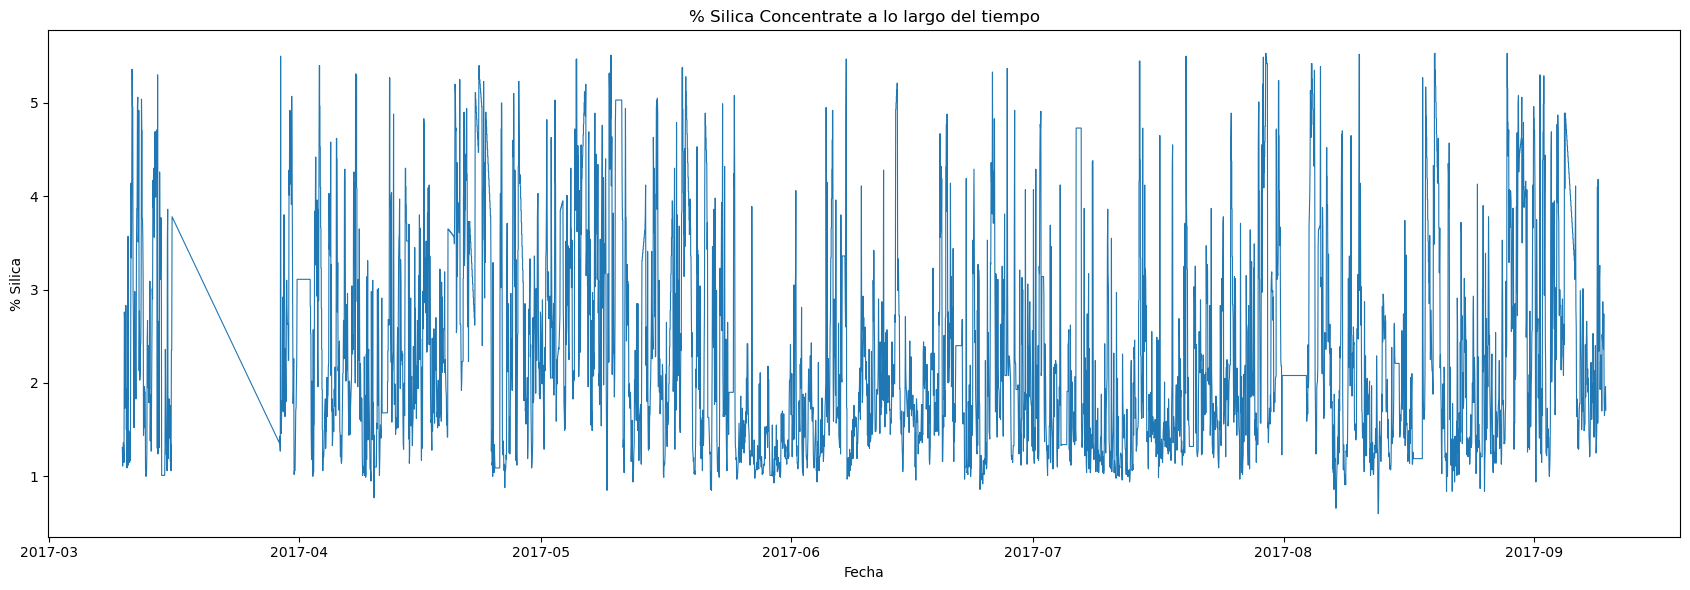

In [34]:
# 7. Serie de tiempo del target
plt.figure(figsize=(17,6))
plt.plot(df.set_index('date')['% Silica Concentrate'], linewidth=0.8)
plt.title('% Silica Concentrate a lo largo del tiempo')
plt.ylabel('% Silica')
plt.xlabel('Fecha')
plt.tight_layout()
plt.show()

In [35]:
df.columns

Index(['date', '% Iron Feed', '% Silica Feed', 'Starch Flow', 'Amina Flow',
       'Ore Pulp Flow', 'Ore Pulp pH', 'Ore Pulp Density',
       'Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow',
       'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow',
       'Flotation Column 05 Air Flow', 'Flotation Column 06 Air Flow',
       'Flotation Column 07 Air Flow', 'Flotation Column 01 Level',
       'Flotation Column 02 Level', 'Flotation Column 03 Level',
       'Flotation Column 04 Level', 'Flotation Column 05 Level',
       'Flotation Column 06 Level', 'Flotation Column 07 Level',
       '% Iron Concentrate', '% Silica Concentrate'],
      dtype='object')

In [36]:
import pandas as pd

# Limpieza de nombres
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Reconstruir timestamp a 20 s (si 'date' no contiene minutos/segundos)
df = df.sort_values('date').reset_index(drop=True)
start = df.loc[0, 'date']
df['timestamp'] = pd.date_range(start=start, periods=len(df), freq='20s')
df.set_index('timestamp', inplace=True, drop=True)

# Definir variables operacionales (excluimos columnas de target y 'date')
oper_vars = [
    c for c in df.columns
    if c not in ['date', '%_iron_concentrate', '%_silica_concentrate']
]

# Resampleo horario: media, desviación, mínimo y máximo
hourly = (
    df[oper_vars]
    .resample('1H')
    .agg(['mean', 'std', 'min', 'max'])
)
# Aplanar MultiIndex
hourly.columns = ['_'.join(col) for col in hourly.columns]

# Añadir target real (% sílice) al inicio de cada hora
hourly['silica_concentrate'] = (
    df['%_silica_concentrate']
    .resample('1H')
    .first()
)

# Crear target adelantado 1 h (pronóstico t+1h)
hourly['silica_concentrate_t_plus_1h'] = hourly['silica_concentrate'].shift(-1)

# Eliminar filas sin target futuro (última hora)
df_model = hourly.dropna(subset=['silica_concentrate_t_plus_1h'])

# Opcional: resetear índice para scikit-learn
df_model = df_model.reset_index().rename(columns={'timestamp': 'hora'})

# Resultado
print("Dataset para modelado:", df_model.shape)
display(df_model.head())


C:\Users\OMEN\AppData\Local\Temp\ipykernel_20316\2386921465.py:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('1H')


Dataset para modelado: (4096, 87)


C:\Users\OMEN\AppData\Local\Temp\ipykernel_20316\2386921465.py:30: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('1H')


,hora,%_iron_feed_mean,%_iron_feed_std,%_iron_feed_min,%_iron_feed_max,%_silica_feed_mean,%_silica_feed_std,%_silica_feed_min,%_silica_feed_max,starch_flow_mean,...,flotation_column_06_level_mean,flotation_column_06_level_std,flotation_column_06_level_min,flotation_column_06_level_max,flotation_column_07_level_mean,flotation_column_07_level_std,flotation_column_07_level_min,flotation_column_07_level_max,silica_concentrate,silica_concentrate_t_plus_1h
0,2017-03-10 01:00:00,55.2,0.0,55.2,55.2,16.98,0.0,16.98,16.98,3171.820581,...,463.754894,29.861186,411.668,555.832,450.466944,41.828759,363.719,551.869,1.31,1.11
1,2017-03-10 02:00:00,55.2,0.0,55.2,55.2,16.98,0.0,16.98,16.98,3131.351500,...,455.745722,19.302706,411.640,515.697,451.043506,36.090460,366.090,537.965,1.11,1.27
2,2017-03-10 03:00:00,55.2,0.0,55.2,55.2,16.98,0.0,16.98,16.98,3486.105222,...,463.803178,32.310133,405.818,629.089,454.222972,43.759786,378.642,643.929,1.27,1.36
3,2017-03-10 04:00:00,55.2,0.0,55.2,55.2,16.98,0.0,16.98,16.98,3213.826325,...,502.950778,55.565146,418.360,630.378,495.168906,64.067179,360.461,644.092,1.36,1.34
4,2017-03-10 05:00:00,55.2,0.0,55.2,55.2,16.98,0.0,16.98,16.98,3327.530850,...,559.802472,27.766358,507.046,646.422,549.717856,28.214565,492.498,640.756,1.34,1.15


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4096 entries, 0 to 4095
Data columns (total 87 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   hora                               4096 non-null   datetime64[ns]
 1   %_iron_feed_mean                   4096 non-null   float64       
 2   %_iron_feed_std                    4096 non-null   float64       
 3   %_iron_feed_min                    4096 non-null   float64       
 4   %_iron_feed_max                    4096 non-null   float64       
 5   %_silica_feed_mean                 4096 non-null   float64       
 6   %_silica_feed_std                  4096 non-null   float64       
 7   %_silica_feed_min                  4096 non-null   float64       
 8   %_silica_feed_max                  4096 non-null   float64       
 9   starch_flow_mean                   4096 non-null   float64       
 10  starch_flow_std                    4

,hora,%_iron_feed_mean,%_iron_feed_std,%_iron_feed_min,%_iron_feed_max,%_silica_feed_mean,%_silica_feed_std,%_silica_feed_min,%_silica_feed_max,starch_flow_mean,...,flotation_column_06_level_mean,flotation_column_06_level_std,flotation_column_06_level_min,flotation_column_06_level_max,flotation_column_07_level_mean,flotation_column_07_level_std,flotation_column_07_level_min,flotation_column_07_level_max,silica_concentrate,silica_concentrate_t_plus_1h
count,4096,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,...,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000
mean,2017-06-03 08:30:00,56.296275,0.042509,56.185359,56.405967,14.649710,0.067676,14.474846,14.825964,2868.951321,...,429.948243,37.956789,325.042998,524.087109,421.026557,37.419850,325.174544,525.692687,2.326251,2.326349
min,2017-03-10 01:00:00,42.740000,0.000000,42.740000,42.740000,1.310000,0.000000,1.310000,1.310000,155.244777,...,213.046789,0.000000,155.841000,250.920192,185.659504,0.000000,175.349000,199.923889,0.600000,0.600000
25%,2017-04-21 16:45:00,52.670000,0.000000,52.610000,52.780000,8.980000,0.000000,8.870000,8.990000,2170.526773,...,354.274793,16.320313,245.817250,461.286000,351.297194,20.283741,256.804000,464.898000,1.440000,1.440000
50%,2017-06-03 08:30:00,56.080000,0.000000,55.990000,56.200000,13.890000,0.000000,13.540000,14.180000,2914.786227,...,407.726914,26.933467,305.671000,518.054000,401.216378,31.832859,313.721000,522.274596,2.000000,2.000000
75%,2017-07-16 00:15:00,59.720000,0.000000,59.720000,59.720000,19.585000,0.000000,19.180000,20.210000,3526.754337,...,497.239552,50.378894,401.925250,578.560000,463.114062,48.266209,392.264000,593.352500,3.010000,3.010000
max,2017-08-27 16:00:00,65.780000,3.067014,65.780000,65.780000,33.400000,3.989833,33.400000,33.400000,6265.084702,...,698.383035,177.505499,698.314562,698.861000,655.489828,202.495767,655.145311,659.902000,5.530000,5.530000
std,NaN,5.153340,0.215680,5.209158,5.104866,6.799205,0.336266,6.723487,6.887720,939.429110,...,75.298471,31.320861,102.210308,85.686283,72.318289,24.293509,94.820557,81.082053,1.124003,1.123932


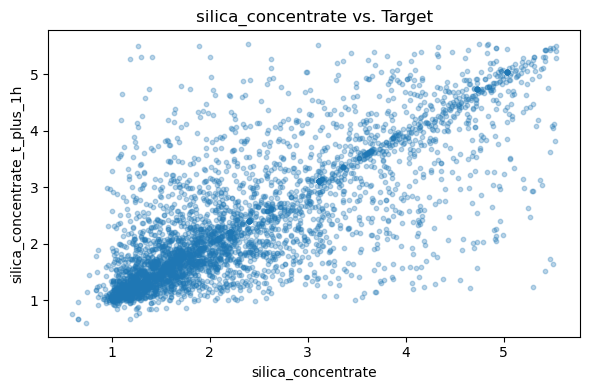

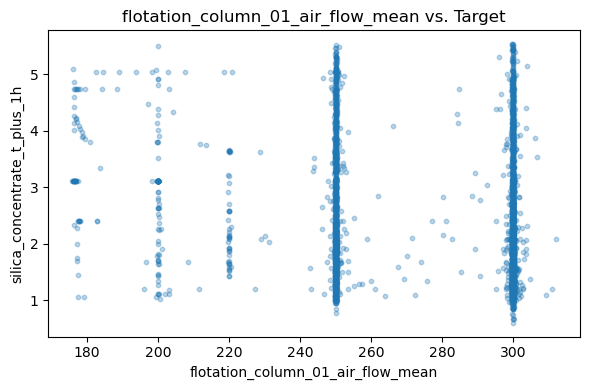

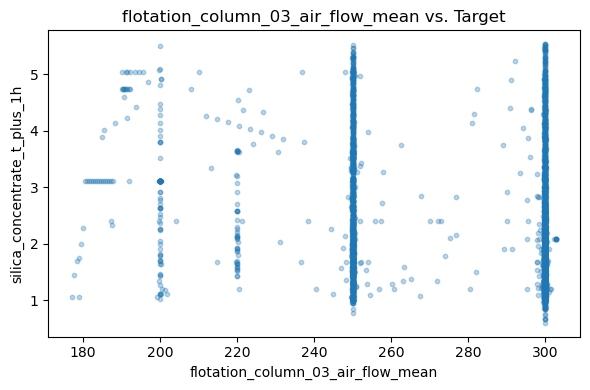

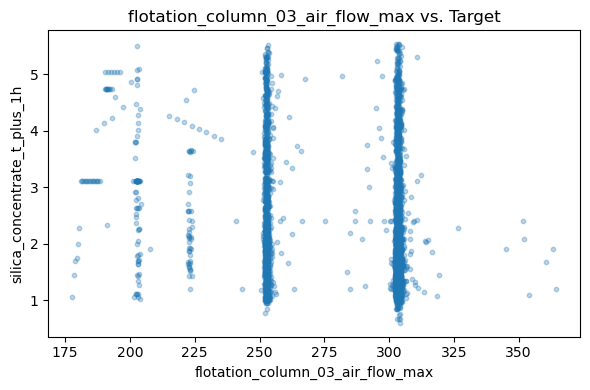

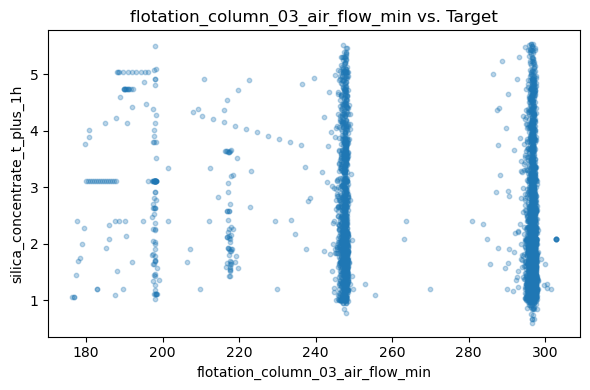

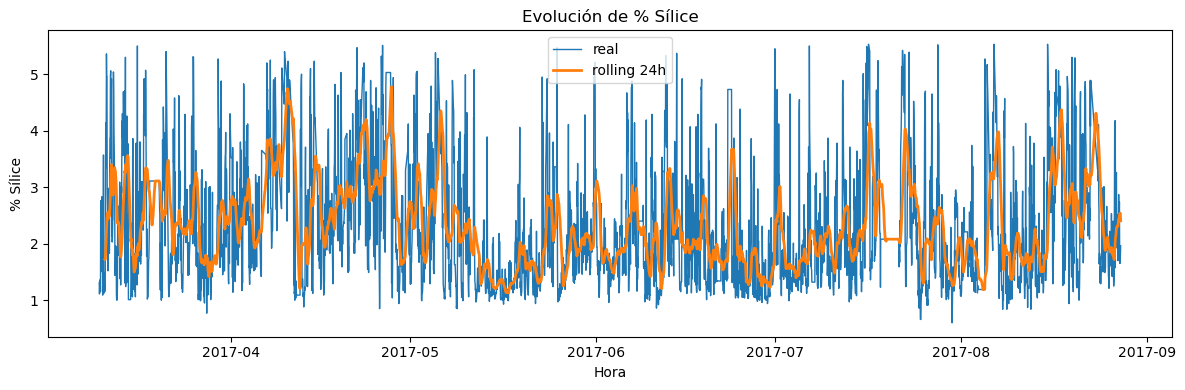

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# asumimos df_model ya cargado
# Resumen rápido
print(df_model.info())
display(df_model.describe())



# correlaciones
corr = df_model.corr()

# Scatter de top-5 correlaciones con el target
top_feats = corr['silica_concentrate_t_plus_1h'].abs().sort_values(ascending=False)[1:6].index
for feat in top_feats:
    plt.figure(figsize=(6,4))
    plt.scatter(df_model[feat], df_model['silica_concentrate_t_plus_1h'], s=10, alpha=0.3)
    plt.xlabel(feat); plt.ylabel('silica_concentrate_t_plus_1h')
    plt.title(f'{feat} vs. Target')
    plt.tight_layout()
    plt.show()

# Serie de tiempo del target real vs. media histórica
plt.figure(figsize=(12,4))
plt.plot(df_model['hora'], df_model['silica_concentrate'], label='real', linewidth=1)
plt.plot(df_model['hora'], df_model['silica_concentrate'].rolling(24).mean(),
         label='rolling 24h', linewidth=2)
plt.legend(); plt.title('Evolución de % Sílice')
plt.xlabel('Hora'); plt.ylabel('% Sílice')
plt.tight_layout()
plt.show()


## Feature Engineering

In [38]:
import pandas as pd
from sklearn.feature_selection import VarianceThreshold

# Separamos X e y
y = df_model['silica_concentrate_t_plus_1h']
X = df_model.drop(['hora','silica_concentrate','silica_concentrate_t_plus_1h'], axis=1)

# Matriz de correlación de features
corr_matrix = X.corr().abs()

# Identificar features a eliminar:  
#    Para cada par (i,j) con i<j, si corr(i,j) ≥ umbral, marcamos j para eliminar
umbral = 0.90
to_drop = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] >= umbral:
            colname = corr_matrix.columns[i]
            to_drop.add(colname)

print(f"Features con corr ≥ {umbral}: {len(to_drop)}: se eliminarán")
print(sorted(to_drop))

# Eliminamos las columnas muy correladas
X_sel = X.drop(columns=to_drop)

# Eliminación de baja varianza (p.ej. threshold=0.01)
sel = VarianceThreshold(threshold=0.01)
sel.fit(X_sel)
low_var = X_sel.columns[~sel.get_support()]
print(f"Features con varianza < 0.01: {len(low_var)} → se eliminarán")
print(list(low_var))

X_sel = pd.DataFrame(
    sel.transform(X_sel),
    columns = X_sel.columns[sel.get_support()],
    index   = X_sel.index
)

# Conjunto final para modelado
df_final = pd.concat([df_model[['hora','silica_concentrate','silica_concentrate_t_plus_1h']], X_sel], axis=1)
print("Shape antes:", df_model.shape)
print("Shape después:", df_final.shape)

df_final.head()


Features con corr ≥ 0.9: 17: se eliminarán
['%_iron_feed_max', '%_iron_feed_min', '%_silica_feed_max', '%_silica_feed_mean', '%_silica_feed_min', '%_silica_feed_std', 'flotation_column_01_air_flow_max', 'flotation_column_01_air_flow_min', 'flotation_column_03_air_flow_max', 'flotation_column_03_air_flow_mean', 'flotation_column_03_air_flow_min', 'flotation_column_06_air_flow_max', 'flotation_column_06_air_flow_min', 'flotation_column_07_air_flow_max', 'flotation_column_07_air_flow_mean', 'ore_pulp_ph_max', 'ore_pulp_ph_min']
Features con varianza < 0.01: 5 → se eliminarán
['ore_pulp_ph_std', 'ore_pulp_density_mean', 'ore_pulp_density_std', 'ore_pulp_density_min', 'ore_pulp_density_max']
Shape antes: (4096, 87)
Shape después: (4096, 65)


,hora,silica_concentrate,silica_concentrate_t_plus_1h,%_iron_feed_mean,%_iron_feed_std,starch_flow_mean,starch_flow_std,starch_flow_min,starch_flow_max,amina_flow_mean,...,flotation_column_05_level_min,flotation_column_05_level_max,flotation_column_06_level_mean,flotation_column_06_level_std,flotation_column_06_level_min,flotation_column_06_level_max,flotation_column_07_level_mean,flotation_column_07_level_std,flotation_column_07_level_min,flotation_column_07_level_max
0,2017-03-10 01:00:00,1.31,1.11,55.2,0.0,3171.820581,543.718159,367.3830,3907.42,577.884333,...,385.216,524.045,463.754894,29.861186,411.668,555.832,450.466944,41.828759,363.719,551.869
1,2017-03-10 02:00:00,1.11,1.27,55.2,0.0,3131.351500,510.716376,1402.3400,4016.60,538.711322,...,358.010,516.910,455.745722,19.302706,411.640,515.697,451.043506,36.090460,366.090,537.965
2,2017-03-10 03:00:00,1.27,1.36,55.2,0.0,3486.105222,155.045569,3197.6600,4049.80,592.172244,...,352.090,574.164,463.803178,32.310133,405.818,629.089,454.222972,43.759786,378.642,643.929
3,2017-03-10 04:00:00,1.36,1.34,55.2,0.0,3213.826325,440.057618,52.7344,3699.22,593.848444,...,366.079,648.112,502.950778,55.565146,418.360,630.378,495.168906,64.067179,360.461,644.092
4,2017-03-10 05:00:00,1.34,1.15,55.2,0.0,3327.530850,554.766790,195.8980,3887.11,619.640106,...,518.750,574.688,559.802472,27.766358,507.046,646.422,549.717856,28.214565,492.498,640.756


In [39]:
# Calcular correlación absoluta de cada feature con el target
corr = df_final.corr()['silica_concentrate_t_plus_1h'].abs()
corr = corr.drop(['silica_concentrate_t_plus_1h', 'silica_concentrate'])  # excluimos targets

# Elegir las k variables más correlacionadas (p.ej. k=10)
k = 5
top_feats = corr.sort_values(ascending=False).head(k).index.tolist()
print("Top features para lag/rolling:", top_feats)


Top features para lag/rolling: ['flotation_column_01_air_flow_mean', 'flotation_column_05_level_mean', 'flotation_column_02_air_flow_mean', 'flotation_column_05_level_min', 'flotation_column_04_level_mean']


In [40]:
from sklearn.feature_selection import VarianceThreshold

lags    = [1, 2, 3]     # desfases en horas
windows = [3, 6, 12]    # ventanas en horas

# Construir nuevo dict con transformaciones
new_feats = {}
for col in top_feats:
    for lag in lags:
        new_feats[f'{col}_lag_{lag}h'] = df_final[col].shift(lag)
    for w in windows:
        roll = df_final[col].rolling(window=w)
        new_feats[f'{col}_roll_{w}h_mean'] = roll.mean()
        new_feats[f'{col}_roll_{w}h_std']  = roll.std()

# DataFrame de transformaciones y concatenación
df_new = pd.DataFrame(new_feats, index=df_final.index)
df_aug = pd.concat([df_final, df_new], axis=1)

# Drop NaNs de esas transformaciones
df_feat = df_aug.dropna()




In [41]:
import numpy as np
# Construye X eliminando los targets
X = df_feat.drop(columns=['silica_concentrate','silica_concentrate_t_plus_1h'])

# Filtra sólo las columnas numéricas
X_num = X.select_dtypes(include=[np.number])
print("Columns antes:", X.shape[1], "sólo numéricas:", X_num.shape[1])

#  Aplica VarianceThreshold sobre X_num
sel = VarianceThreshold(threshold=0.01)
X_sel_arr = sel.fit_transform(X_num)

# Reconstruye DataFrame con las columnas retenidas
cols_sel = X_num.columns[sel.get_support()]
X_sel = pd.DataFrame(X_sel_arr, columns=cols_sel, index=X_num.index)

# Monta el dataset final listo para modelado
df_model_ready = (
    pd.concat([X_sel, df_feat['silica_concentrate_t_plus_1h']], axis=1)
      .reset_index(drop=False)
      .rename(columns={'index':'hora'})
)

print("Shape final para modelado:", df_model_ready.shape)
display(df_model_ready.head())

Columns antes: 108 sólo numéricas: 107
Shape final para modelado: (4085, 109)


,hora,%_iron_feed_mean,%_iron_feed_std,starch_flow_mean,starch_flow_std,starch_flow_min,starch_flow_max,amina_flow_mean,amina_flow_std,amina_flow_min,...,flotation_column_04_level_mean_lag_1h,flotation_column_04_level_mean_lag_2h,flotation_column_04_level_mean_lag_3h,flotation_column_04_level_mean_roll_3h_mean,flotation_column_04_level_mean_roll_3h_std,flotation_column_04_level_mean_roll_6h_mean,flotation_column_04_level_mean_roll_6h_std,flotation_column_04_level_mean_roll_12h_mean,flotation_column_04_level_mean_roll_12h_std,silica_concentrate_t_plus_1h
0,11,54.950000,0.000000,4492.574667,200.344779,3864.96,5064.45,559.975339,10.557989,536.224,...,550.202906,548.488766,550.898306,550.124469,1.597928,550.287411,1.067211,520.870857,44.870897,1.50
1,12,54.950000,0.000000,4706.878111,427.669482,4096.58,5341.80,543.106989,10.024595,516.968,...,551.681733,550.202906,548.488766,551.152078,0.823849,550.469507,1.192322,529.331159,39.560202,1.94
2,13,54.950000,0.000000,4291.485444,314.086002,3772.66,5560.16,529.971361,11.598720,503.784,...,551.571594,551.681733,550.202906,552.356887,1.265982,551.110106,1.766811,537.949944,31.176727,1.09
3,14,54.984667,0.187206,5403.860556,344.824653,4588.87,6049.41,516.947672,7.309476,489.075,...,553.817333,551.571594,551.681733,552.368802,1.256584,551.246635,1.778781,546.231960,15.748312,1.51
4,15,55.990000,0.000000,5320.356944,182.199009,4821.88,5640.63,525.892817,33.472819,469.971,...,551.717478,553.817333,551.571594,551.801889,1.974593,551.476983,1.399205,550.687062,1.378558,1.96


In [47]:
# Separar X e y

import pandas as pd

# Asegúrate de que 'hora' es datetime
df_model_ready['hora'] = pd.to_datetime(df_model_ready['hora'])

# Definir cutoff para las últimas 4 semanas
cutoff = df_model_ready['hora'].max() - pd.Timedelta(weeks=4)

# Máscaras
mask_train = df_model_ready['hora'] < cutoff
mask_test  = df_model_ready['hora'] >= cutoff

# Separar X e y para train
X_train = df_model_ready.loc[mask_train] \
            .drop(columns=['hora','silica_concentrate_t_plus_1h'])
y_train = df_model_ready.loc[mask_train, 'silica_concentrate_t_plus_1h']

# Separar X e y para test
X_test  = df_model_ready.loc[mask_test] \
            .drop(columns=['hora','silica_concentrate_t_plus_1h'])
y_test  = df_model_ready.loc[mask_test, 'silica_concentrate_t_plus_1h']

# Verificar shapes
print("Train shapes:", X_train.shape, y_train.shape)
print("Test  shapes:", X_test.shape,  y_test.shape)


Train shapes: (0, 107) (0,)
Test  shapes: (4085, 107) (4085,)


In [43]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

pipeline = Pipeline([
    ('model', RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    ))
])


In [ ]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import numpy as np

tscv = TimeSeriesSplit(n_splits=5)
# Usamos MAPE como métrica (sklearn devuelve negativa)
scores = -cross_val_score(
    pipeline, X_train, y_train,
    cv=tscv,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=-1
)

print(f"MAPE CV (baseline): {np.mean(scores):.2%}  ±  {np.std(scores):.2%}")



MAPE CV (baseline): 52.26%  ±  11.83%


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import numpy as np

pipeline = Pipeline([
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# 2. Espacio de búsqueda de hiperparámetros
param_dist = {
    'model__n_estimators': randint(100, 1000),
    'model__max_depth':    [None] + list(randint(5, 50).rvs(10)),
    'model__max_features': ['sqrt', 'log2', 0.2, 0.5, 0.8],
    'model__min_samples_split': randint(2, 20),
    'model__min_samples_leaf':  randint(1, 10),
    'model__bootstrap':         [True, False]
}

# 3. Configurar CV temporal y búsqueda aleatoria
tscv = TimeSeriesSplit(n_splits=5)
search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=50,                     # número de combinaciones a probar
    scoring='neg_mean_absolute_percentage_error',
    cv=tscv,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# 4. Ejecutar búsqueda
search.fit(X_train, y_train)

# 5. Resultados clave
best = search.best_estimator_
best_mape = -search.best_score_
print(f"Mejor MAPE CV tras tuning: {best_mape:.2%}")
print("Mejores hiperparámetros:")
for p, v in search.best_params_.items():
    print(f"   • {p}: {v}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits


KeyboardInterrupt: 

In [ ]:
import optuna
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score


tscv = TimeSeriesSplit(n_splits=5)

def objective(trial):
    # Sugerir hiperparámetros
    params = {
        'n_estimators':       trial.suggest_int('n_estimators', 100, 1000),
        'max_depth':          trial.suggest_int('max_depth', 5, 50),
        'max_features':       trial.suggest_categorical('max_features', ['sqrt','log2', 0.2, 0.5, 0.8]),
        'min_samples_split':  trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf':   trial.suggest_int('min_samples_leaf', 1, 10),
        'bootstrap':          trial.suggest_categorical('bootstrap', [True, False]),
        'random_state':       42,
        'n_jobs':             -1
    }
    # Montar pipeline con el sugerido
    model = RandomForestRegressor(**params)
    pipeline = Pipeline([('model', model)])
    
    # Validación cross‐val para MAPE
    scores = -cross_val_score(
        pipeline, X_train, y_train,
        cv=tscv, # Validación temporal
        scoring='neg_mean_absolute_percentage_error',
        n_jobs=-1
    )
    # Queremos minimizar el MAPE medio
    return np.mean(scores)

#  Crear y correr el estudio
study = optuna.create_study(
    direction='minimize',
    study_name='rf_optuna',
    sampler=optuna.samplers.TPESampler(seed=42)
)
study.optimize(objective, n_trials=50, show_progress_bar=True)

#  Resultados
print("Mejor MAPE CV:", f"{study.best_value:.2%}")
print("Mejores parámetros:")
for key, val in study.best_params.items():
    print(f" • {key}: {val}")

# Crear el modelo final con los mejores parámetros
best_model = Pipeline([(
    'model',
    RandomForestRegressor(**study.best_params, random_state=42, n_jobs=-1)
)])
best_model.fit(X, y)


[I 2025-07-10 23:43:18,714] A new study created in memory with name: rf_optuna


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-07-10 23:43:25,490] Trial 0 finished with value: 0.48906089430206406 and parameters: {'n_estimators': 437, 'max_depth': 48, 'max_features': 'sqrt', 'min_samples_split': 18, 'min_samples_leaf': 7, 'bootstrap': True}. Best is trial 0 with value: 0.48906089430206406.
[I 2025-07-10 23:45:09,002] Trial 1 finished with value: 0.5155950679967469 and parameters: {'n_estimators': 973, 'max_depth': 43, 'max_features': 0.8, 'min_samples_split': 10, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 0 with value: 0.48906089430206406.
[I 2025-07-10 23:45:12,119] Trial 2 finished with value: 0.47937734131967147 and parameters: {'n_estimators': 363, 'max_depth': 21, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 7, 'bootstrap': True}. Best is trial 2 with value: 0.47937734131967147.
[I 2025-07-10 23:45:30,354] Trial 3 finished with value: 0.49052772137958645 and parameters: {'n_estimators': 954, 'max_depth': 49, 'max_features': 'sqrt', 'min_samples_split': 4, 'min_s

KeyboardInterrupt: 